# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from susceptibility_scores import construct_paths_and_dataset_kwargs

### Preamble

In [17]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "YagoECQ"
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"
SEED = 0
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 500
MAX_ENTITIES = 100
CAP_PER_TYPE = False
ABLATE_OUT_RELEVANT_CONTEXTS = False
UNIFORM_CONTEXTS = True
DEDUPLICATE_ENTITIES = True

OVERWRITE = True
ENTITY_TYPES = ["entities", "gpt_fake_entities"]
# ENTITY_TYPES = ["entities", "fake_entities"]
QUERY_TYPES = ["closed", "open"]
# QUERY_TYPES = ["closed"]
# ANSWER_MAP = {
#     0: [1621, 642, 7651, 2302, 2369, 7716],
#     1: [6279, 4754, 22487, 4374, 9820, 24239],
# }
ANSWER_MAP = None

# Model parameters
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

In [18]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)
QUERY_IDS = list(yago_qec.keys())
QUERY_ID = QUERY_IDS[0]
QUERY_ID = "reverse-http://schema.org/manufacturer"
SUBNAME = f"{extract_name_from_yago_uri(QUERY_ID)[0]}_{extract_name_from_yago_uri(QUERY_ID)[1]}"
QUERY_IDS[:5], len(QUERY_IDS)

(['http://schema.org/alumniOf',
  'http://schema.org/duration',
  'reverse-http://schema.org/director',
  'http://schema.org/address',
  'http://schema.org/duns'],
 56)

In [19]:
for qid, v in yago_qec.items():
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/alumniOf 1000 999
http://schema.org/duration 1000 999
reverse-http://schema.org/director 1000 936
http://schema.org/address 1000 997
http://schema.org/duns 119 119
http://schema.org/founder 1000 987
http://schema.org/elevation 1000 998
reverse-http://schema.org/editor 378 314
http://schema.org/lyricist 1000 960
http://schema.org/memberOf 1000 999
http://schema.org/about 1000 991
http://schema.org/gtin 21 18
http://schema.org/administrates 1000 800
http://schema.org/leader 1000 943
http://schema.org/illustrator 226 216
http://schema.org/material 1000 962
http://schema.org/children 1000 994
http://schema.org/dateCreated 1000 999
http://schema.org/editor 378 263
reverse-http://schema.org/lyricist 1000 746
http://schema.org/actor 1000 991
reverse-http://schema.org/memberOf 1000 841
http://schema.org/director 1000 998
http://schema.org/contentLocation 1000 992
http://schema.org/homeLocation 1000 995
http://schema.org/knowsLanguage 1000 1000
http://schema.org/dissolutionDat

In [20]:
# Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    answers_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID=QUERY_ID,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    OVERWRITE=OVERWRITE,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

Data dir: data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [21]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ


In [22]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

Overwriting datasets (if they already exist) at data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/entities.json, data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/answers.json, data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/contexts.json, and data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/queries.json.
Number of entities in each entity type must be the same, instead received lengths [1000, 386] ['entities', 'gpt_fake_entities']. Truncating entity size per type to be 386


In [23]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [24]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


{'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 0, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'OVERWRITE': True, 'ENTITY_TYPES': ['entities', 'gpt_fake_entities'], 'QUERY_TYPES': ['closed', 'open'], 'BATCH_SZ': 16, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['yago', 'analysis'], 'LOG_DATASETS': True, 'QUERY_IDS': ['http://schema.org/alumniOf', 'http://schema.org/duration', 'reverse-http://schema.org/director', 'http://schema.org/address', 'http://schema.org/duns', 'http://schema.org/founder', 'http://schema.org/elevation', 'reverse-http://schema.org/editor', 'http://schema.org/lyricist', 'http://schema.org/memberOf', 'http://schema.org/about', 'http://schema.org/gtin', 'http://schema.org/administrates', 'http://schema.org/leader', 'http://schema.org/

### Load Data

In [26]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path,
    index_col=0,
    converters={"contexts": literal_eval, "entity": literal_eval},
)

In [27]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs)... 

Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2af3422d0850>.


Done. 0.2s


### Analyze Data

In [28]:
val_df_contexts_per_qe.head()

q_id  \
0  reverse-http://schema.org/manufacturer   
1  reverse-http://schema.org/manufacturer   
2  reverse-http://schema.org/manufacturer   
3  reverse-http://schema.org/manufacturer   
4  reverse-http://schema.org/manufacturer   

                                          query_form                 entity  \
0  Q: Is/was {entity} the manufacturer of {answer...      (Lucas Bertrand,)   
1  Q: Is/was {entity} the manufacturer of {answer...         (McAfee, LLC,)   
2  Q: Is/was {entity} the manufacturer of {answer...         (Aker Verdal,)   
3  Q: Is/was {entity} the manufacturer of {answer...      (General Motors,)   
4  Q: Is/was {entity} the manufacturer of {answer...  (Platform Computing,)   

                  answer                                           contexts  \
0             GNV Spirit  [AEG manufactured U-178.\n, AEG manufactured T...   
1       McAfee VirusScan  [AEG manufactured U-178.\n, AEG manufactured T...   
2         Byford Dolphin  [AEG manufactured U-178.\n, AEG manufactured T...   
3            Bedford VAL  [AEG manufactured U-178.\n, AEG manufactured T...   
4  IBM Spectrum Symphony  [AEG manufactured U-178.\n, AEG manufactured T...   

   susceptibility_score                                 full_query_example  
0              0.049862  AEG manufactured U-178.\nQ: Is/was Lucas Bertr...  
1              0.046615  AEG manufactured U-178.\nQ: Is/was McAfee, LLC...  
2              0.065984  AEG manufactured U-178.\nQ: Is/was Aker Verdal...  
3              0.040336  AEG manufactured U-178.\nQ: Is/was General Mot...  
4              0.031693  AEG manufactured U-178.\nQ: Is/was Platform Co...

In [29]:
val_df_contexts_per_qe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q_id                  400 non-null    object 
 1   query_form            400 non-null    object 
 2   entity                400 non-null    object 
 3   answer                400 non-null    object 
 4   contexts              400 non-null    object 
 5   susceptibility_score  400 non-null    float64
 6   full_query_example    400 non-null    object 
dtypes: float64(1), object(6)
memory usage: 25.0+ KB


In [30]:
val_df_contexts_per_qe["entity"].value_counts()

(Lucas Bertrand,)       4
(Perry Engineering,)    4
(Elias Fuentes,)        4
(Rheinmetall AG,)       4
(Kai Makoto,)           4
                       ..
(Mikael Abramov,)       4
(Leila Al-F,)           4
(Ayla Kaya,)            4
(Saab Group,)           4
(Lucas de Oliveira,)    4
Name: entity, Length: 100, dtype: int64

In [31]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['AEG manufactured U-178.\n',
 'AEG manufactured Tu-134.\n',
 'AEG manufactured C.9.\n',
 'AEG manufactured AFL Live.\n',
 'AEG manufactured Excitebots: Trick Racing.\n',
 'Aarav Malhotra manufactured SR Battle of Britain class 21C153 “Sir Keith Park”.\n',
 'Aarav Malhotra manufactured Virgin Webplayer.\n',
 'Aarav Malhotra manufactured SS William A. Graham.\n',
 'Aarav Malhotra manufactured Internet Channel.\n',
 'Aarav Malhotra manufactured Reggiane Re.2005 Sagittario.\n']

In [32]:
# import re

# p = r"of\s(.*?)(?=\sis\b)"
# c_ents = [
#     re.search(p, text).group(1) for text in val_df_contexts_per_qe.iloc[0]["contexts"]
# ]
# ents = val_df_contexts_per_qe["entity"].tolist()
# if (
#     DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
#     and len(set(c_ents).intersection(set(ents))) != 0
# ):
#     raise ValueError(
#         "ablate_out_relevant_contexts is True, but the contexts contain entities in the entities list."
#     )

In [92]:
entities_df_tidy = pd.DataFrame(
    [
        (k, ent)
        for k, ents in yago_qec[QUERY_ID].items()
        for ent in ents
        if k in {"entities", "fake_entities", "gpt_fake_entities"}
    ],
    columns=["type", "entity"],
)
entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))

In [61]:
# entities_df = pd.DataFrame(
#     {k: v for k, v in yago_qec[QUERY_ID].items() if k in {"entities", "fake_entities", "gpt_fake_entities"}}
# )
# real_ents = set(entities_df["entities"])
# fake_ents = set(entities_df["fake_entities"])
# print("# unique real ents:", len(real_ents))
# print("# unique fake ents:", len(fake_ents))
# print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
# print("Overlapping ents:", real_ents.intersection(fake_ents))
# print(entities_df["entities"].value_counts(), entities_df["fake_entities"].value_counts())

# entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
# print(entities_df_tidy.head())
# entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
# entities_df_tidy.head()
# entities_df_tidy.info()

In [93]:
entities_df_tidy = entities_df_tidy.drop_duplicates()

In [94]:
entities_df_tidy["entity"].value_counts()

(Mazda,)                                  2
(Nintendo,)                               2
(Sony,)                                   2
(Motorola,)                               2
(EMGE,)                                   1
                                         ..
(Apple Computer,)                         1
(The Postmaster Project Incorporated,)    1
(Insuburan,)                              1
(Springfield Armory,)                     1
(Armando Andersson,)                      1
Name: entity, Length: 2066, dtype: int64

In [95]:
entities_df_tidy[entities_df_tidy["type"] == "entities"][
    "entity"
].value_counts(), entities_df_tidy[entities_df_tidy["type"] == "fake_entities"][
    "entity"
].value_counts()

((Fincantieri,)                      1
 (Chicago Bridge & Iron Company,)    1
 (Bethlehem Atlantic Works,)         1
 (JFE Holdings,)                     1
 (Taito,)                            1
                                    ..
 (Changan Automobile,)               1
 (Ability Plus Software,)            1
 (Audi,)                             1
 (Feadship,)                         1
 (Springfield Armory,)               1
 Name: entity, Length: 684, dtype: int64,
 (Insuburan,)                                  1
 (Parestal Parestal,)                          1
 (Depe Depe,)                                  1
 (Call Formation,)                             1
 (National Union for Radio and Television,)    1
                                              ..
 (Democratic Party,)                           1
 (Volvo Conservative,)                         1
 (Sound Sound,)                                1
 (Equites,)                                    1
 (Soundsoundsoundsound,)               

In [96]:
s_multiple_entities = entities_df_tidy["entity"].value_counts() > 1
# set(s_multiple_entities[s_multiple_entities].index)
# val_df_contexts_per_qe["entity"].isin(
#     set(s_multiple_entities[s_multiple_entities].index)
# )

In [97]:
val_df_contexts_per_qe["entity"].value_counts()

(Lucas Bertrand,)       4
(Perry Engineering,)    4
(Elias Fuentes,)        4
(Rheinmetall AG,)       4
(Kai Makoto,)           4
                       ..
(Mikael Abramov,)       4
(Leila Al-F,)           4
(Ayla Kaya,)            4
(Saab Group,)           4
(Lucas de Oliveira,)    4
Name: entity, Length: 100, dtype: int64

In [98]:
# val_df_contexts_per_qe["entity"]
entities_df_tidy["entity"].isin(
    set(val_df_contexts_per_qe["entity"]).intersection(set(entities_df_tidy["entity"]))
).value_counts()

False    1970
True      100
Name: entity, dtype: int64

In [99]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    entities_df_tidy,
    left_on="entity",
    right_on="entity",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "contexts",
        "type",
        "susceptibility_score",
    ]
]
val_df_per_qe

q_id  \
0    reverse-http://schema.org/manufacturer   
1    reverse-http://schema.org/manufacturer   
2    reverse-http://schema.org/manufacturer   
3    reverse-http://schema.org/manufacturer   
4    reverse-http://schema.org/manufacturer   
..                                      ...   
395  reverse-http://schema.org/manufacturer   
396  reverse-http://schema.org/manufacturer   
397  reverse-http://schema.org/manufacturer   
398  reverse-http://schema.org/manufacturer   
399  reverse-http://schema.org/manufacturer   

                                            query_form                 entity  \
0    Q: Is/was {entity} the manufacturer of {answer...      (Lucas Bertrand,)   
1    Q: Is/was {entity} the manufacturer of {answer...         (McAfee, LLC,)   
2    Q: Is/was {entity} the manufacturer of {answer...         (Aker Verdal,)   
3    Q: Is/was {entity} the manufacturer of {answer...      (General Motors,)   
4    Q: Is/was {entity} the manufacturer of {answer...  (Platform Computing,)   
..                                                 ...                    ...   
395                              {entity} manufactured       (Cesar Fuentes,)   
396                              {entity} manufactured          (Aisha Saad,)   
397                              {entity} manufactured      (Van's Aircraft,)   
398                              {entity} manufactured          (Tommo Inc.,)   
399                              {entity} manufactured   (Lucas de Oliveira,)   

                             answer  \
0                        GNV Spirit   
1                  McAfee VirusScan   
2                    Byford Dolphin   
3                       Bedford VAL   
4             IBM Spectrum Symphony   
..                              ...   
395               Convair Model 118   
396                           WRC 6   
397                           RV-10   
398                       Neo-Geo X   
399  Achaea, Dreams of Divine Lands   

                                              contexts               type  \
0    [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
1    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
2    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
3    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
4    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
..                                                 ...                ...   
395  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
396  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
397  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
398  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
399  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   

     susceptibility_score  
0                0.049862  
1                0.046615  
2                0.065984  
3                0.040336  
4                0.031693  
..                    ...  
395              2.000545  
396              2.158536  
397              0.538271  
398              1.664095  
399              2.045728  

[400 rows x 7 columns]

In [100]:
val_df_per_qe["entity"].value_counts()

(Lucas Bertrand,)       4
(Perry Engineering,)    4
(Elias Fuentes,)        4
(Rheinmetall AG,)       4
(Kai Makoto,)           4
                       ..
(Mikael Abramov,)       4
(Leila Al-F,)           4
(Ayla Kaya,)            4
(Saab Group,)           4
(Lucas de Oliveira,)    4
Name: entity, Length: 100, dtype: int64

In [101]:
query_forms = val_df_per_qe["query_form"].unique()
query_forms

array(['Q: Is/was {entity} the manufacturer of {answer}?\nA:',
       'Q: Is/was {answer} manufactured by {entity}?\nA:',
       'Q: What is one thing manufactured by {entity}?\nA:',
       '{entity} manufactured'], dtype=object)

In [102]:
closed_qfs = yago_qec[QUERY_ID]["query_forms"]["closed"]
open_qfs = yago_qec[QUERY_ID]["query_forms"]["open"]

val_df_per_qe.loc[val_df_per_qe["query_form"].isin(closed_qfs), "query_type"] = "closed"
val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"
val_df_per_qe

q_id  \
0    reverse-http://schema.org/manufacturer   
1    reverse-http://schema.org/manufacturer   
2    reverse-http://schema.org/manufacturer   
3    reverse-http://schema.org/manufacturer   
4    reverse-http://schema.org/manufacturer   
..                                      ...   
395  reverse-http://schema.org/manufacturer   
396  reverse-http://schema.org/manufacturer   
397  reverse-http://schema.org/manufacturer   
398  reverse-http://schema.org/manufacturer   
399  reverse-http://schema.org/manufacturer   

                                            query_form                 entity  \
0    Q: Is/was {entity} the manufacturer of {answer...      (Lucas Bertrand,)   
1    Q: Is/was {entity} the manufacturer of {answer...         (McAfee, LLC,)   
2    Q: Is/was {entity} the manufacturer of {answer...         (Aker Verdal,)   
3    Q: Is/was {entity} the manufacturer of {answer...      (General Motors,)   
4    Q: Is/was {entity} the manufacturer of {answer...  (Platform Computing,)   
..                                                 ...                    ...   
395                              {entity} manufactured       (Cesar Fuentes,)   
396                              {entity} manufactured          (Aisha Saad,)   
397                              {entity} manufactured      (Van's Aircraft,)   
398                              {entity} manufactured          (Tommo Inc.,)   
399                              {entity} manufactured   (Lucas de Oliveira,)   

                             answer  \
0                        GNV Spirit   
1                  McAfee VirusScan   
2                    Byford Dolphin   
3                       Bedford VAL   
4             IBM Spectrum Symphony   
..                              ...   
395               Convair Model 118   
396                           WRC 6   
397                           RV-10   
398                       Neo-Geo X   
399  Achaea, Dreams of Divine Lands   

                                              contexts               type  \
0    [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
1    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
2    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
3    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
4    [AEG manufactured U-178.\n, AEG manufactured T...           entities   
..                                                 ...                ...   
395  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
396  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
397  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
398  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
399  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   

     susceptibility_score query_type  
0                0.049862     closed  
1                0.046615     closed  
2                0.065984     closed  
3                0.040336     closed  
4                0.031693     closed  
..                    ...        ...  
395              2.000545       open  
396              2.158536       open  
397              0.538271       open  
398              1.664095       open  
399              2.045728       open  

[400 rows x 8 columns]

In [103]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

q_id  \
81  reverse-http://schema.org/manufacturer   
87  reverse-http://schema.org/manufacturer   
85  reverse-http://schema.org/manufacturer   
57  reverse-http://schema.org/manufacturer   
45  reverse-http://schema.org/manufacturer   
..                                     ...   
96  reverse-http://schema.org/manufacturer   
48  reverse-http://schema.org/manufacturer   
56  reverse-http://schema.org/manufacturer   
24  reverse-http://schema.org/manufacturer   
6   reverse-http://schema.org/manufacturer   

                                           query_form  \
81  Q: Is/was {entity} the manufacturer of {answer...   
87  Q: Is/was {entity} the manufacturer of {answer...   
85  Q: Is/was {entity} the manufacturer of {answer...   
57  Q: Is/was {entity} the manufacturer of {answer...   
45  Q: Is/was {entity} the manufacturer of {answer...   
..                                                ...   
96  Q: Is/was {entity} the manufacturer of {answer...   
48  Q: Is/was {entity} the manufacturer of {answer...   
56  Q: Is/was {entity} the manufacturer of {answer...   
24  Q: Is/was {entity} the manufacturer of {answer...   
6   Q: Is/was {entity} the manufacturer of {answer...   

                                     entity                 answer  \
81                           (Škoda Works,)     Škoda 7 cm K10 gun   
87         (Digital Equipment Corporation,)                  VT180   
85  (Hudswell, Clarke and Company Limited,)  Barry Railway Class J   
57               (Canonical Group Limited,)           Ubuntu GNOME   
45                     (Ubisoft Blue Byte,)              Anno 2205   
..                                      ...                    ...   
96                            (Aisha Saad,)                  WRC 6   
48                          (Omar Al-Saud,)              equalizer   
56                          (Fiona Moreno,)                  Rb 08   
24                          (Aria Mendoza,)         Grand Princess   
6                             (Mateo Cruz,)                    E4U   

                                             contexts               type  \
81  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
87  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
85  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
57  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
45  [AEG manufactured U-178.\n, AEG manufactured T...           entities   
..                                                ...                ...   
96  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
48  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
56  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
24  [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   
6   [AEG manufactured U-178.\n, AEG manufactured T...  gpt_fake_entities   

    susceptibility_score query_type  
81              0.023431     closed  
87              0.024061     closed  
85              0.026312     closed  
57              0.027456     closed  
45              0.027685     closed  
..                   ...        ...  
96              0.071510     closed  
48              0.072843     closed  
56              0.075111     closed  
24              0.078918     closed  
6               0.081700     closed  

[100 rows x 8 columns]

In [104]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]][
    ["entity", "type", "susceptibility_score"]
].sort_values(by="susceptibility_score")

entity               type  \
81                           (Škoda Works,)           entities   
87         (Digital Equipment Corporation,)           entities   
85  (Hudswell, Clarke and Company Limited,)           entities   
57               (Canonical Group Limited,)           entities   
45                     (Ubisoft Blue Byte,)           entities   
..                                      ...                ...   
96                            (Aisha Saad,)  gpt_fake_entities   
48                          (Omar Al-Saud,)  gpt_fake_entities   
56                          (Fiona Moreno,)  gpt_fake_entities   
24                          (Aria Mendoza,)  gpt_fake_entities   
6                             (Mateo Cruz,)  gpt_fake_entities   

    susceptibility_score  
81              0.023431  
87              0.024061  
85              0.026312  
57              0.027456  
45              0.027685  
..                   ...  
96              0.071510  
48              0.072843  
56              0.075111  
24              0.078918  
6               0.081700  

[100 rows x 3 columns]

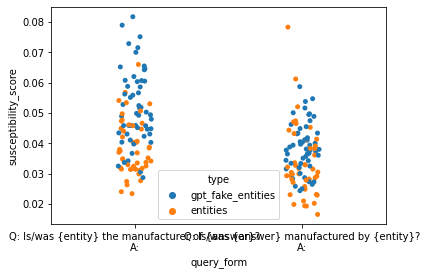

In [105]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plot_name = f"plot_susscore_vs_queryform_real_fake_{SUBNAME}"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

<AxesSubplot:xlabel='entity_mentions_in_contexts', ylabel='susceptibility_score'>

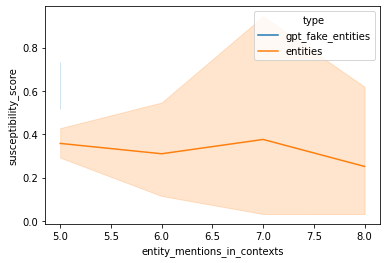

In [106]:
val_df_per_qe["entity_mentions_in_contexts"] = val_df_per_qe.apply(
    lambda row: sum([row["entity"][0] in context for context in row["contexts"]]),
    axis=1,
)
sns.lineplot(
    data=val_df_per_qe,
    x="entity_mentions_in_contexts",
    y="susceptibility_score",
    hue="type",
)
# val_df_per_qe

In [107]:
def construct_df_given_query_id(query_id: str, verbose=True):
    # Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
    (
        data_dir,
        input_dir,
        entities_path,
        contexts_path,
        queries_path,
        answers_path,
        val_data_path,
        model_dir,
        results_dir,
        val_results_path,
        data_id,
        model_id,
        DATASET_KWARGS_IDENTIFIABLE,
    ) = construct_paths_and_dataset_kwargs(
        DATASET_NAME=DATASET_NAME,
        RAW_DATA_PATH=RAW_DATA_PATH,
        SEED=SEED,
        MODEL_ID=MODEL_ID,
        LOAD_IN_8BIT=LOAD_IN_8BIT,
        QUERY_ID=query_id,
        MAX_CONTEXTS=MAX_CONTEXTS,
        MAX_ENTITIES=MAX_ENTITIES,
        CAP_PER_TYPE=CAP_PER_TYPE,
        UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
        DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
        ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
        OVERWRITE=OVERWRITE,
        ENTITY_TYPES=ENTITY_TYPES,
        QUERY_TYPES=QUERY_TYPES,
        ANSWER_MAP=ANSWER_MAP,
    )
    # Analysis dir
    analysis_dir = os.path.join(data_dir, "analysis")
    if verbose:
        print(f"Analysis dir: {analysis_dir}")
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)

    # Set random seeds
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    from ast import literal_eval

    try:
        val_df_contexts_per_qe = pd.read_csv(
            val_results_path,
            index_col=0,
            converters={"contexts": literal_eval, "entity": literal_eval},
        )
    except FileNotFoundError as e:
        print(f"Unable to find file at {val_results_path}, full error: {e}")
        return None
    if verbose:
        print("val_df_contexts_per_qe info:")
        print(val_df_contexts_per_qe.info())
        print(val_df_contexts_per_qe["entity"].value_counts())
        print(val_df_contexts_per_qe.iloc[0]["contexts"][:10])

    entities_df_tidy = pd.DataFrame(
        [
            (k, ent)
            for k, ents in yago_qec[QUERY_ID].items()
            for ent in ents
            if k in {"entities", "fake_entities", "gpt_fake_entities"}
        ],
        columns=["type", "entity"],
    )
    entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))

    #     entities_df = pd.DataFrame(
    #         {
    #             k: v
    #             for k, v in yago_qec[query_id].items()
    #             if k in {"entities", "fake_entities"}
    #         }
    #     )
    #     real_ents = set(entities_df["entities"])
    #     fake_ents = set(entities_df["fake_entities"])

    #     entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
    #     entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
    #     entities_df_tidy = entities_df_tidy.drop_duplicates()
    #     if verbose:
    #         print("Entities info:")
    #         print("# unique real ents:", len(real_ents))
    #         print("# unique fake ents:", len(fake_ents))
    #         print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
    #         print("Overlapping ents:", real_ents.intersection(fake_ents))
    #         print(
    #             entities_df["entities"].value_counts(),
    #             entities_df["fake_entities"].value_counts(),
    #         )
    #         print(entities_df_tidy.head())
    #         print(entities_df_tidy.info())

    val_df_per_qe = val_df_contexts_per_qe.merge(
        entities_df_tidy,
        left_on="entity",
        right_on="entity",
        how="left",
    )[
        [
            "q_id",
            "query_form",
            "entity",
            "answer",
            "contexts",
            "type",
            "susceptibility_score",
        ]
    ]
    query_forms = val_df_per_qe["query_form"].unique()
    closed_qfs = yago_qec[query_id]["query_forms"]["closed"]
    open_qfs = yago_qec[query_id]["query_forms"]["open"]

    val_df_per_qe.loc[
        val_df_per_qe["query_form"].isin(closed_qfs), "query_type"
    ] = "closed"
    val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"

    if verbose:
        print("val_df_per_qe info:")
        print(val_df_per_qe)

        print(f"query forms: {query_forms}")
        print(
            "Sorted sus scores:",
            val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
                by="susceptibility_score"
            ),
        )

    return val_df_per_qe

In [108]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(query_id, verbose=False)
    for query_id in QUERY_IDS
}

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/El

In [109]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/motto', 'http://schema.org/award', 'reverse-http://schema.org/editor', 'http://schema.org/gtin', 'http://schema.org/editor', 'http://schema.org/founder'}


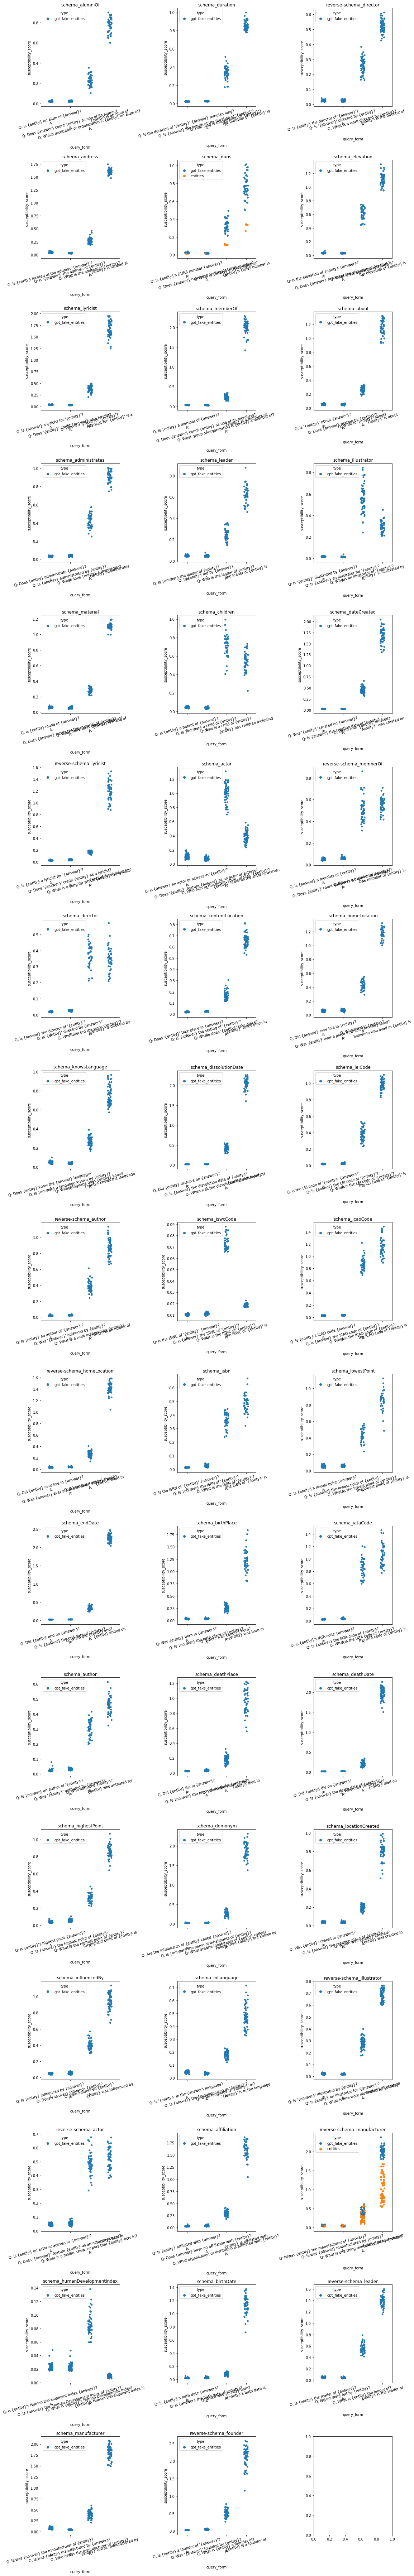

In [110]:
import math

num_plots = len(qid_to_val_df_per_qe)
num_cols = 3
num_rows = math.ceil(num_plots // 3) + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(16, 100))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    row = math.ceil(count // num_cols)
    col = count % num_cols
    ax = axes[row][col]
    sns.stripplot(
        data=df,
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        # hue="is_real",
        # dodge=True
        # jitter=0.1,
        # legend="full",
    )
    subname = (
        f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
    )
    ax.set_title(subname)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
    count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

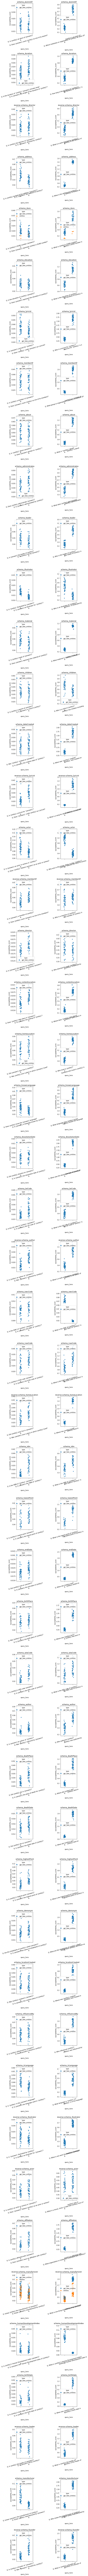

In [111]:
import math

num_rows = len(qid_to_val_df_per_qe)
num_cols = 2
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(8, 250))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    for qt in ["closed", "open"]:
        row = math.ceil(count // num_cols)
        col = count % num_cols
        ax = axes[row][col]
        sns.stripplot(
            data=df[df["query_type"] == qt],
            x="query_form",
            y="susceptibility_score",
            hue="type",
            ax=ax,
            # hue="is_real",
            # dodge=True
            # jitter=0.1,
            # legend="full",
        )
        subname = (
            f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
        )
        ax.set_title(subname)
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)
        count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all_open_vs_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [112]:
from scipy.stats import ttest_ind


def ttest(df):
    sus_scores_real = df[df["type"] == "entities"]["susceptibility_score"]
    sus_scores_fake = df[df["type"] == "fake_entities"]["susceptibility_score"]
    ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    ttest_res = ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    t_stat, p_value = ttest_res.statistic, ttest_res.pvalue
    # print(t_stat, p_value)
    cohen_d = t_stat * np.sqrt(
        (len(sus_scores_real) + len(sus_scores_fake))
        / (len(sus_scores_real) * len(sus_scores_fake))
    )
    cohen_d2 = (np.mean(sus_scores_real) - np.mean(sus_scores_fake)) / np.sqrt(
        (
            np.var(sus_scores_real, ddof=1) * (len(sus_scores_real) - 1)
            + np.var(sus_scores_fake, ddof=1) * (len(sus_scores_fake) - 1)
        )
        / (len(sus_scores_real) + len(sus_scores_fake) - 2)
    )
    assert np.isclose(cohen_d, cohen_d2)
    # effect_size,
    return {
        "effect_size": cohen_d,
        "p_value": p_value,
        "n": len(sus_scores_fake) + len(sus_scores_real),
    }


# ttest_scores = [{"query": k, **ttest(v)} for k, v in qid_to_val_df_per_qe.items()]
ttest_scores = [
    {"query": k, **ttest(v[v["query_type"] == "closed"])}
    for k, v in qid_to_val_df_per_qe.items()
]
# ttest_scores = [{"query": k, **ttest(v[v["query_type"] == "open"])} for k, v in qid_to_val_df_per_qe.items()]

pd.DataFrame(ttest_scores).sort_values(by="p_value").reset_index(drop=True)

ZeroDivisionError: division by zero

In [84]:
construct_df_given_query_id("reverse-http://schema.org/manufacturer", verbose=True)
# qid_to_val_df_per_qe["reverse-http://schema.org/manufacturer"]["type"].value_counts()

Data dir: data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Analysis dir: data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/analysis
val_df_contexts_per_qe info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q_id                  400 non-null    object 
 1   query_form            400 non-null    object 
 2   entity                400 non-null    object 
 3   answer                400 non-null    objec

q_id  \
0    reverse-http://schema.org/manufacturer   
1    reverse-http://schema.org/manufacturer   
2    reverse-http://schema.org/manufacturer   
3    reverse-http://schema.org/manufacturer   
4    reverse-http://schema.org/manufacturer   
..                                      ...   
395  reverse-http://schema.org/manufacturer   
396  reverse-http://schema.org/manufacturer   
397  reverse-http://schema.org/manufacturer   
398  reverse-http://schema.org/manufacturer   
399  reverse-http://schema.org/manufacturer   

                                            query_form                 entity  \
0    Q: Is/was {entity} the manufacturer of {answer...      (Lucas Bertrand,)   
1    Q: Is/was {entity} the manufacturer of {answer...         (McAfee, LLC,)   
2    Q: Is/was {entity} the manufacturer of {answer...         (Aker Verdal,)   
3    Q: Is/was {entity} the manufacturer of {answer...      (General Motors,)   
4    Q: Is/was {entity} the manufacturer of {answer...  (Platform Computing,)   
..                                                 ...                    ...   
395                              {entity} manufactured       (Cesar Fuentes,)   
396                              {entity} manufactured          (Aisha Saad,)   
397                              {entity} manufactured      (Van's Aircraft,)   
398                              {entity} manufactured          (Tommo Inc.,)   
399                              {entity} manufactured   (Lucas de Oliveira,)   

                             answer  \
0                        GNV Spirit   
1                  McAfee VirusScan   
2                    Byford Dolphin   
3                       Bedford VAL   
4             IBM Spectrum Symphony   
..                              ...   
395               Convair Model 118   
396                           WRC 6   
397                           RV-10   
398                       Neo-Geo X   
399  Achaea, Dreams of Divine Lands   

                                              contexts type  \
0    [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
1    [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
2    [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
3    [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
4    [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
..                                                 ...  ...   
395  [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
396  [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
397  [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
398  [AEG manufactured U-178.\n, AEG manufactured T...  NaN   
399  [AEG manufactured U-178.\n, AEG manufactured T...  NaN   

     susceptibility_score query_type  
0                0.049862     closed  
1                0.046615     closed  
2                0.065984     closed  
3                0.040336     closed  
4                0.031693     closed  
..                    ...        ...  
395              2.000545       open  
396              2.158536       open  
397              0.538271       open  
398              1.664095       open  
399              2.045728       open  

[400 rows x 8 columns]

### Examining model outputs

In [ ]:
# TODO: (1) try answer_map thing, and also (2) randomly sample so that each entity shows up in contexts evenly

In [ ]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [ ]:
def print_top_k_next_token_probs(
    model, tokenizer, query, entity, context, answer=None, k=50
):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(
                    query=query, entity=entity, context=context, answer=answer
                ),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [ ]:
val_df_contexts_per_qe.info(), val_df_per_qe.info()

In [ ]:
val_df_per_qe.drop(
    columns=["contexts", "type", "q_id", "entity_mentions_in_contexts"]
).value_counts()

In [ ]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

In [ ]:
entity_to_context_mentions = {
    entity: sum([entity[0] in context for context in val_df_per_qe.iloc[0]["contexts"]])
    for entity in val_df_per_qe["entity"].unique()
}
entity_to_context_mentions = dict(
    sorted(entity_to_context_mentions.items(), key=lambda x: x[1])
)
print("Number of contexts each entity is mentioned in:")
entity_to_context_mentions

In [ ]:
pp = pprint.PrettyPrinter()
query_id = "reverse-http://schema.org/manufacturer"
val_df_per_qe = qid_to_val_df_per_qe[query_id]
# print(val_df_per_qe)
row = (
    val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]]
    .sort_values(by="susceptibility_score")
    .iloc[0]
)
entity = row["entity"]
answer = row["answer"]
print("entity:", entity)
contexts = row["contexts"]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context="", answer=answer))
print(
    "CMI:",
    estimate_cmi(query, entity, contexts, model, tokenizer, answer_entity=answer),
)

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(
    model, tokenizer, query, entity, context="", k=50, answer=answer
)
print("\n\n")
print("Top-k next token probs WITH context mentioning entity")
for context in contexts:
    if entity[0] in context:
        print(
            f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
        )
        print_top_k_next_token_probs(
            model, tokenizer, query, entity, context, k=50, answer=answer
        )
        print("\n\n")
print("\n\n")
print("Top-k next token probs WITH context NOT mentioning entity")
for context in contexts[:5]:
    print(
        f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
    )
    print_top_k_next_token_probs(
        model, tokenizer, query, entity, context, k=50, answer=answer
    )
    print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context="", answer=answer),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

In [ ]:
tokenizer([" Nope"])

### Correlation with Pile frequency

In [ ]:
unigram_frequencies = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-unigrams.bin",
    dtype=np.int64,
    mode="r",
    shape=(50277,),
)
view = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia_pile_idxmaps/pile_0.87_deduped_text_document.bin",
    dtype=np.uint16,
    mode="r",
)

In [ ]:
import zstandard as zstd
import pickle
from scipy.sparse import load_npz

file_path = (
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-deduped-bigrams.zst"
)
# # Open the zstd file for reading in binary mode
# with open(file_path, 'rb') as compressed_file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(compressed_file) as reader:
#         # Decompress the zstd file and load the pickled data
#         pickled_data = pickle.loads(reader.read())

# Reconstruct the SciPy sparse array
# sparse_array = load_npz(pickled_data)

with open(file_path, "rb") as f:
    data = f.read()

dctx = zstd.ZstdDecompressor()
decompressed = dctx.decompress(data)
pickled_scipy = pickle.loads(decompressed)

In [ ]:
len(decompressed), type(decompressed), decompressed[:5]

In [ ]:
entities = val_df_contexts_per_qe["entity"].apply(lambda x: x[0]).unique().tolist()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)
tokenized_entities = [tuple(e) for e in tokenizer(entities)["input_ids"]]
tokenized_entities_prespace = [
    tuple(e) for e in tokenizer([" " + e for e in entities])["input_ids"]
]
tokenized_entities
tokenized_entities_prespace
entities_to_freqs = {
    e: {tokenized_entities[i]: 0, tokenized_entities_prespace[i]: 0}
    for i, e in enumerate(entities)
}
entities_to_freqs["Zimbabwe"]

# tokenized_entities
# {
#     entity:
#         {
#             tokens_without_space: count,
#             tokens_with_space: count
#         }
# }

In [ ]:
# relevant_token_seqs = set(tokenized_entities + tokenized_entities_prespace)
relevant_token_seqs = set(tokenized_entities_prespace)
relevant_token_seqs

In [ ]:
from collections import Counter

unigram_tokens = {
    t: unigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 1
}
unigram_tokens

In [ ]:
bigram_tokens = {
    t: bigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 2
}

In [ ]:
for e, freq_dicts in entities_to_freqs.items():
    total = 0
    for token_seqs in freq_dicts.keys():
        if len(token_seqs) == 1:
            freq_dicts[token_seqs] = unigram_frequencies[token_seqs[0]]
        if len(token_seqs) == 2:
            freq_dicts[token_seqs] = bigram_frequencies[token_seqs]
        total += freq_dicts[token_seqs]
    freq_dicts["total"] = total

In [ ]:
entities_to_freqs

In [ ]:
entity_counts = dict(
    sorted(
        {
            (k,): v["total"] for k, v in entities_to_freqs.items() if v["total"] != 0
        }.items(),
        key=lambda x: x[1],
    )
)
ent_freq_df = pd.DataFrame(
    list(entity_counts.items()), columns=["entity", "ent_frequency"]
)
ent_freq_df

In [ ]:
val_df_per_qe_with_freq = val_df_per_qe.merge(ent_freq_df)
val_df_per_qe_with_freq["log_ent_frequency"] = val_df_per_qe_with_freq[
    "ent_frequency"
].apply(np.log)
val_df_per_qe_with_freq

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df = val_df_per_qe_with_freq[val_df_per_qe_with_freq["query_form"] == query_forms[0]]
plot = sns.regplot(
    data=df,
    x="log_ent_frequency",
    y="susceptibility_score",
    # logx=True,
    # hue="query_form",
    ax=ax,
    label=True,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

for i, row in df.iterrows():
    ax.text(
        row["log_ent_frequency"],
        row["susceptibility_score"],
        row["entity"],
        ha="right",
        va="bottom",
    )

plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic_ent_frequency"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# 24000 min = 2+ weeks of CPU hours to finish lmao
from tqdm.auto import trange
CHUNK_SIZE = 50_000_000
VOCAB_SIZE = 50_277
window_size = 1
for i in trange(0, len(view), CHUNK_SIZE):
    chunk = view[i : i + CHUNK_SIZE]
    for j in trange(len(chunk) - (window_size - 1)):
        ngram = tuple(chunk[j: j+window_size])
        if ngram in unigram_tokens:
            unigram_tokens[ngram] += 1        
    # counts += np.bincount(chunk, minlength=len(counts))

In [ ]:
unigram_frequencies

In [ ]:
tokenizer.convert_ids_to_tokens([38581])

In [ ]:
wandb.finish()